In [1]:
import os
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
gpu_num = 0
if gpus:
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

# Import Sionna
import sys
print(os.getcwd())
sys.path.append('../')
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    print('no sionna')
    # os.system("pip install sionna")
    # import sionna
  
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/afs/cs.pitt.edu/usr0/zha21/Documents/GitHub/sionna-new/sionna/examples


In [2]:
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              orientation=[0,0,0])
# Add receiver instance to scene
scene.add(rx)
tx.look_at(rx) # Transmitter points towards receiver
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [3]:
import time
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies
traced_paths = scene.trace_paths(max_depth=5,
                                num_samples=1e6) 
bandwidth = 1e8
freq = np.arange(2e9, 3e9, bandwidth)
start_time = time.time()
cfr_all = []
for f in freq:
    print(f'compute fields at frequency: {f}')
    scene.frequency = f # in Hz; implicitly updates RadioMaterials
    paths = scene.compute_fields(*traced_paths) 
    # a [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    a, tau = paths.cir() 
    # CFR [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
    cfr = cir_to_ofdm_channel(bandwidth, a, tau) 
    cfr_all.append(cfr)
    
cfr = tf.concat(cfr_all, axis=-1)
end_time = time.time()
elapsed_time = end_time - start_time 
print(f"Elapsed time: {elapsed_time} seconds")

compute fields at frequency: 2000000000.0
compute fields at frequency: 2100000000.0
compute fields at frequency: 2200000000.0
compute fields at frequency: 2300000000.0
compute fields at frequency: 2400000000.0
compute fields at frequency: 2500000000.0
compute fields at frequency: 2600000000.0
compute fields at frequency: 2700000000.0
compute fields at frequency: 2800000000.0
compute fields at frequency: 2900000000.0
Elapsed time: 18.923330068588257 seconds


tf.Tensor([ 1  1  1  1  1  1 10], shape=(7,), dtype=int32)


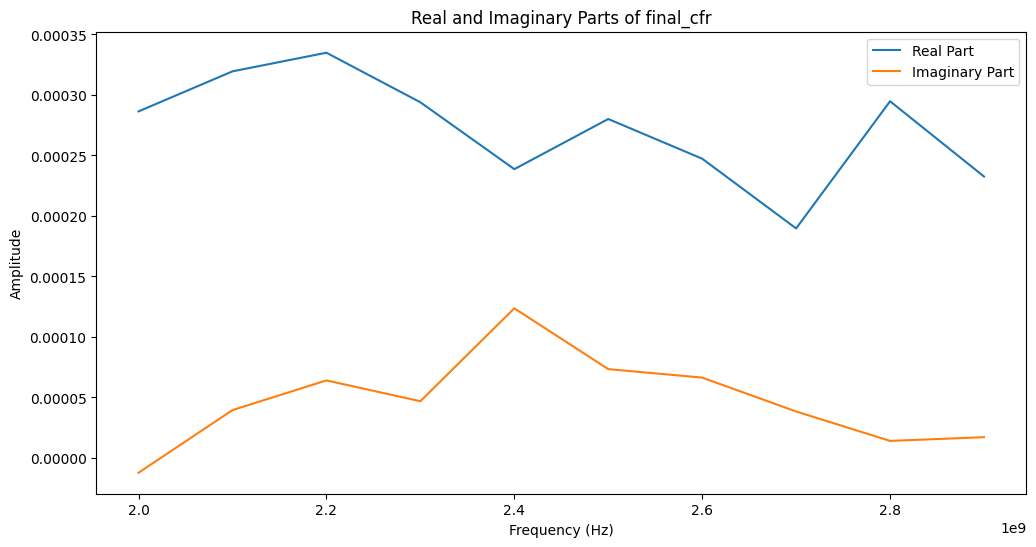

In [4]:
import matplotlib.pyplot as plt

real_part = tf.math.real(cfr)
imag_part = tf.math.imag(cfr)
print(tf.shape(real_part))
real_part_slice = real_part.numpy()[0, 0, 0, 0, 0, 0, :]
imag_part_slice = imag_part.numpy()[0, 0, 0, 0, 0, 0, :]

plt.figure(figsize=(12, 6))
plt.plot(freq, real_part_slice, label='Real Part')
plt.plot(freq, imag_part_slice, label='Imaginary Part')
plt.title('Real and Imaginary Parts of final_cfr')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Elapsed time: 5.664027452468872 seconds
tf.Tensor([10], shape=(1,), dtype=int32)


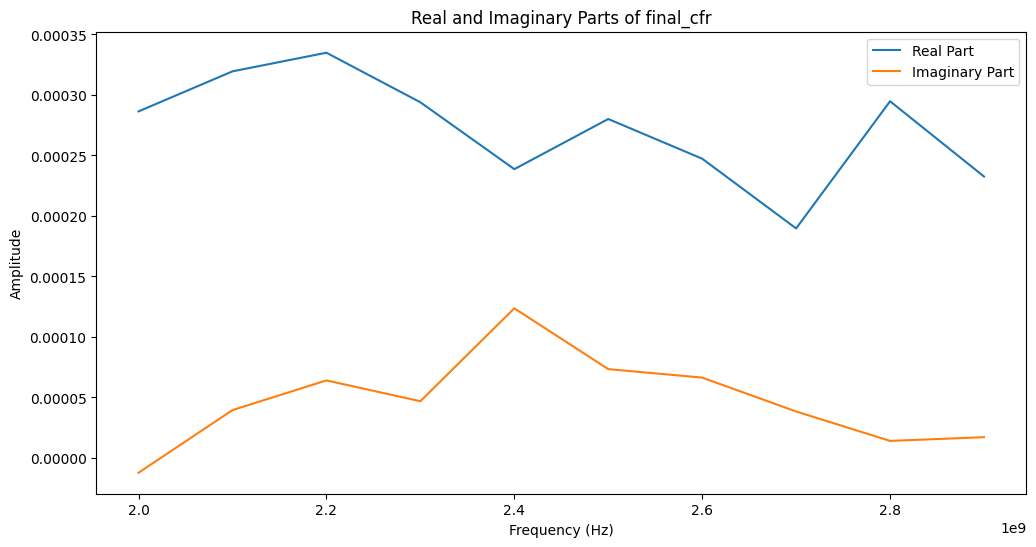

In [6]:
@tf.function
def process_freq(frequency):
    scene.frequency = frequency
    paths = scene.compute_fields(*traced_paths, scat_random_phases=False, check_scene=False)
    a, tau = paths.cir()
    cfr = cir_to_ofdm_channel(bandwidth, a, tau)
    return cfr
    
start_time = time.time()
cfr = tf.map_fn(process_freq, freq, dtype=tf.complex64)
end_time = time.time()
elapsed_time = end_time-start_time
print(f"Elapsed time: {elapsed_time} seconds")

cfr = tf.squeeze(cfr)
real_part = tf.math.real(cfr)
imag_part = tf.math.imag(cfr)
print(tf.shape(real_part))
real_part_slice = real_part.numpy()
imag_part_slice = imag_part.numpy()

plt.figure(figsize=(12, 6))
plt.plot(freq, real_part_slice, label='Real Part')
plt.plot(freq, imag_part_slice, label='Imaginary Part')
plt.title('Real and Imaginary Parts of final_cfr')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()